python -m venv yolo_env
source yolo_env/bin/activate
pip install notebook ipykernel
pip install --upgrade pip
python -m ipykernel install --user --name=yolo_env --display-name "Python (yolo_env)"
pip install torch
pip install ultralytics
pip install opencv-python
pip install pymunk
pip install numpy
pip install matplotlib


0: 736x1280 1 frame, 1 red ball, 1 table, 1 white ball, 1 yellow ball, 29.4ms
Speed: 6.3ms preprocess, 29.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Table: {'cls_name': 'table', 'x1': tensor(381.6940, device='cuda:0'), 'y1': tensor(178.7554, device='cuda:0'), 'x2': tensor(1535.1182, device='cuda:0'), 'y2': tensor(751.3900, device='cuda:0'), 'confidence': tensor(0.9720, device='cuda:0')}
Objects: [{'cls_name': 'frame', 'x1': tensor(322.2486, device='cuda:0'), 'y1': tensor(113.8523, device='cuda:0'), 'x2': tensor(1605.1394, device='cuda:0'), 'y2': tensor(820.5328, device='cuda:0'), 'confidence': tensor(0.9618, device='cuda:0')}, {'cls_name': 'white ball', 'x1': tensor(408.8045, device='cuda:0'), 'y1': tensor(401.6271, device='cuda:0'), 'x2': tensor(440.3823, device='cuda:0'), 'y2': tensor(434.5295, device='cuda:0'), 'confidence': tensor(0.9072, device='cuda:0')}, {'cls_name': 'yellow ball', 'x1': tensor(523.0640, device='cuda:0'), 'y1': tensor(205.2792, device

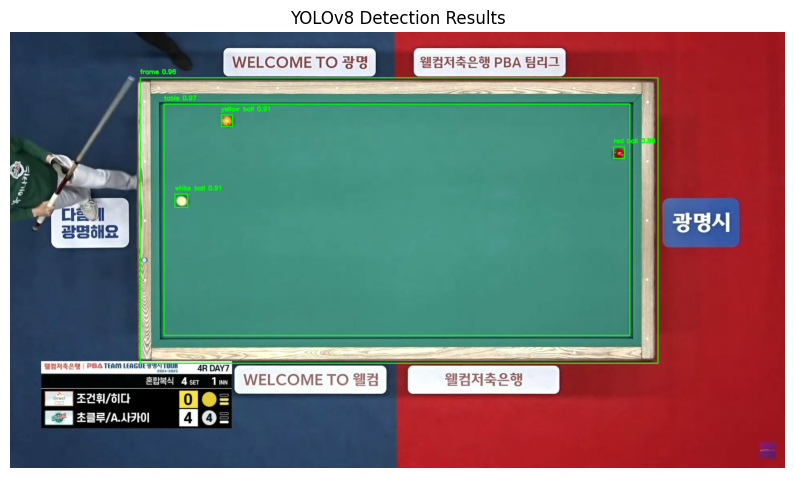

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline  

from ultralytics import YOLO
import cv2
import torch

# 1) YOLO 모델 로드
model_path = "best_jihye.pt"
model = YOLO(model_path)

# 2) 이미지 로드
image_path = "test_img.jpg"
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Could not load image: {image_path}")

# 3) 모델 추론
results = model.predict(source=image, conf=0.5)

# 4) 당구대, 공, 프레임 등 저장할 구조
table = None
objects = []

# 5) 바운딩 박스 표시
for result in results:
    for box in result.boxes:
        # 바운딩 박스 정보
        x1, y1, x2, y2 = box.xyxy[0]
        conf = box.conf[0]
        cls_id = int(box.cls[0])

        # 사각형 그리기 위한 int 변환
        ix1, iy1, ix2, iy2 = map(int, [x1, y1, x2, y2])

        # 클래스 ID → 이름 매핑
        class_map = {
            0: "blue ball", 
            1: "frame", 
            2: "red ball", 
            3: "table",
            4: "white ball", 
            5: "yellow ball"
        }
        cls_name = class_map.get(cls_id, f"Unknown({cls_id})")

        # OpenCV로 바운딩 박스 그리기
        cv2.rectangle(image, (ix1, iy1), (ix2, iy2), (0, 255, 0), 2)

        # 라벨(클래스명 + 신뢰도) 표시
        label = f"{cls_name} {conf:.2f}"
        cv2.putText(
            image, label, (ix1, max(iy1 - 10, 0)),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2
        )

        # 아래는 원하는 로직에 따라 table/objects 분류
        if cls_id == 3:  # table
            table = {
                "cls_name": "table",
                "x1": x1, "y1": y1, "x2": x2, "y2": y2,
                "confidence": conf
            }
        else:
            objects.append({
                "cls_name": cls_name,
                "x1": x1, "y1": y1, "x2": x2, "y2": y2,
                "confidence": conf
            })

# 테이블 없으면 기본값
if table is None:
    table = {
        "cls_name": "table(default)",
        "x1": 0, "y1": 0, "x2": 1280, "y2": 720,
        "confidence": 1.0
    }

print("Table:", table)
print("Objects:", objects)

# 시각화(디버깅용)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("YOLOv8 Detection Results")
plt.show()


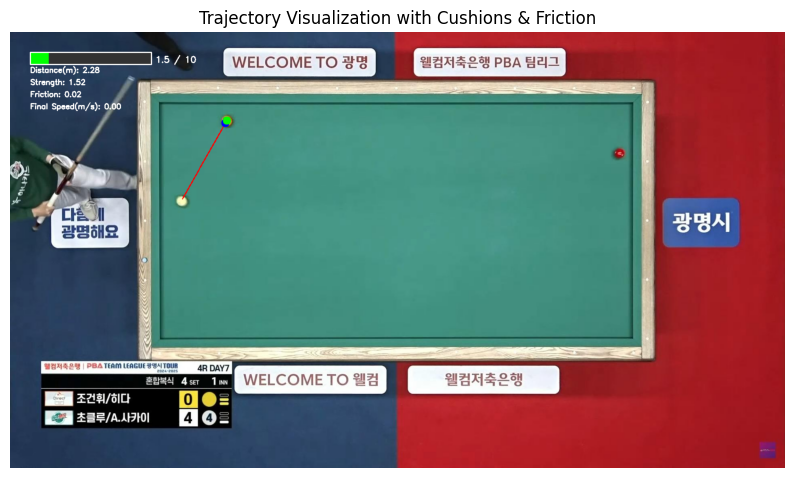

In [8]:
import pymunk
from pymunk import Vec2d
import numpy as np
import torch  # 텐서 변환을 위해 필요
import cv2
import matplotlib.pyplot as plt

##############################################################################
# 헬퍼 함수: GPU 텐서 -> CPU float 변환
##############################################################################
def to_cpu_float(value):
    """
    텐서(tensor)이든 파이썬 숫자이든 상관없이,
    파이썬 float으로 안전하게 변환해주는 함수.
    """
    if isinstance(value, torch.Tensor):
        return float(value.detach().cpu().item())
    else:
        return float(value)

##############################################################################
# 2-1) 공 좌표 추출
##############################################################################
# YOLO 결과 기반 (이미 확보된 데이터 사용)
white_ball = next(obj for obj in objects if obj["cls_name"] == "white ball")
target_ball = next(obj for obj in objects if obj["cls_name"] in ["red ball", "yellow ball"])

# 바운딩 박스 정보에서 GPU 텐서 -> CPU float 변환
white_x1 = to_cpu_float(white_ball["x1"])
white_y1 = to_cpu_float(white_ball["y1"])
white_x2 = to_cpu_float(white_ball["x2"])
white_y2 = to_cpu_float(white_ball["y2"])

target_x1 = to_cpu_float(target_ball["x1"])
target_y1 = to_cpu_float(target_ball["y1"])
target_x2 = to_cpu_float(target_ball["x2"])
target_y2 = to_cpu_float(target_ball["y2"])

# 바운딩 박스 중심 → 픽셀 좌표
white_pos = np.array([
    (white_x1 + white_x2) / 2.0,
    (white_y1 + white_y2) / 2.0
])
target_pos = np.array([
    (target_x1 + target_x2) / 2.0,
    (target_y1 + target_y2) / 2.0
])

# 테이블 정보 (픽셀)도 혹시 텐서면 변환
table_x1 = to_cpu_float(table["x1"])
table_y1 = to_cpu_float(table["y1"])
table_x2 = to_cpu_float(table["x2"])
table_y2 = to_cpu_float(table["y2"])

# 물리 월드로 변환할 때의 스케일(예: 100픽셀 = 1m 로 가정)
PIXELS_TO_METERS = 100.0

# Pymunk를 위한 월드 좌표 (m단위로 변환)
white_pos_world = (white_pos / PIXELS_TO_METERS).tolist()
target_pos_world = (target_pos / PIXELS_TO_METERS).tolist()

##############################################################################
# 2-2) Pymunk 초기화
##############################################################################
space = pymunk.Space()
space.gravity = (0, 0)

##############################################################################
# 2-3) 테이블 경계(쿠션) 생성
##############################################################################
table_world_min = (table_x1 / PIXELS_TO_METERS, table_y1 / PIXELS_TO_METERS)
table_world_max = (table_x2 / PIXELS_TO_METERS, table_y2 / PIXELS_TO_METERS)

cushion_thickness = 0.01  # 쿠션 선의 '두께' 용도
elasticity = 0.9

cushions = [
    pymunk.Segment(space.static_body, 
                   (table_world_min[0], table_world_min[1]), 
                   (table_world_max[0], table_world_min[1]), 
                   cushion_thickness),
    pymunk.Segment(space.static_body, 
                   (table_world_min[0], table_world_max[1]), 
                   (table_world_max[0], table_world_max[1]), 
                   cushion_thickness),
    pymunk.Segment(space.static_body, 
                   (table_world_min[0], table_world_min[1]), 
                   (table_world_min[0], table_world_max[1]), 
                   cushion_thickness),
    pymunk.Segment(space.static_body, 
                   (table_world_max[0], table_world_min[1]), 
                   (table_world_max[0], table_world_max[1]), 
                   cushion_thickness),
]

for c in cushions:
    c.elasticity = 0.9
    space.add(c)

##############################################################################
# 2-4) 공 생성
##############################################################################
mass = 1.0
radius = 0.05  # 월드 좌표(0.05m = 지름 약 10cm)
moment = pymunk.moment_for_circle(mass, 0, radius)

# 흰 공(동적)
white_ball_body = pymunk.Body(mass, moment)
white_ball_body.position = white_pos_world
white_ball_shape = pymunk.Circle(white_ball_body, radius)
white_ball_shape.elasticity = 0.9
space.add(white_ball_body, white_ball_shape)

# 목표 공(정적)
target_ball_body = pymunk.Body(body_type=pymunk.Body.STATIC)
target_ball_body.position = target_pos_world
target_ball_shape = pymunk.Circle(target_ball_body, radius)
space.add(target_ball_body, target_ball_shape)

##############################################################################
# 2-5) 초기 속도 및 방향 설정
##############################################################################
direction_vector = target_ball_body.position - white_ball_body.position
distance = direction_vector.length
direction_unit = direction_vector.normalized() if distance > 0 else Vec2d(1,0)

# 강도 계산 (최대 거리 설정)
max_distance = 15.0  # (단위: m)
strength = min((distance / max_distance) * 10, 10)

# 속도(크기) 설정 (간단히 strength * 일정계수 = 속도)
initial_speed = strength * 2.0  # 최대 20 m/s 가정

white_ball_body.velocity = direction_unit * initial_speed

##############################################################################
# 2-6) 시뮬레이션 (마찰력 적용)
##############################################################################
friction_coefficient = 0.02  # 값이 높을수록 마찰 큼

dt = 1/60.0
simulation_steps = 300  # 5초 정도

positions = []
for step in range(simulation_steps):
    space.step(dt)
    
    # 마찰에 의한 속도 감소(수동 적용)
    v = white_ball_body.velocity
    speed_now = v.length
    if speed_now > 0:
        friction_force = friction_coefficient * speed_now
        speed_new = max(speed_now - friction_force * dt, 0)
        if speed_new < 0.01:  # 거의 멈췄다고 판단
            white_ball_body.velocity = (0, 0)
        else:
            white_ball_body.velocity = v.normalized() * speed_new
    
    positions.append((white_ball_body.position.x, white_ball_body.position.y))

##############################################################################
# 2-7) 궤적 시각화 (OpenCV)
##############################################################################
# 원본 이미지 재로드
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Cannot load {image_path}")

for i in range(len(positions) - 1):
    x1, y1 = positions[i]
    x2, y2 = positions[i + 1]

    # 월드좌표 → 픽셀 좌표
    px1, py1 = int(x1 * PIXELS_TO_METERS), int(y1 * PIXELS_TO_METERS)
    px2, py2 = int(x2 * PIXELS_TO_METERS), int(y2 * PIXELS_TO_METERS)
    cv2.line(image, (px1, py1), (px2, py2), (0, 0, 255), 2)

# 공 위치 표시(최종 위치)
final_px = int(white_ball_body.position.x * PIXELS_TO_METERS)
final_py = int(white_ball_body.position.y * PIXELS_TO_METERS)
cv2.circle(image, (final_px, final_py), 10, (255, 0, 0), -1)

# 목표 공 표시(정적)
target_px = int(target_ball_body.position.x * PIXELS_TO_METERS)
target_py = int(target_ball_body.position.y * PIXELS_TO_METERS)
cv2.circle(image, (target_px, target_py), 10, (0, 255, 0), -1)

##############################################################################
# 2-8) 강도 게이지 바 및 디버그 텍스트
##############################################################################
def draw_gauge_bar(image, strength_val, max_strength=10, position=(50, 50), size=(300, 30)):
    x, y = position
    width, height = size
    # 배경
    cv2.rectangle(image, (x, y), (x + width, y + height), (50, 50, 50), -1)
    # 현재 강도
    current_width = int((strength_val / max_strength) * width)
    cv2.rectangle(image, (x, y), (x + current_width, y + height), (0, 255, 0), -1)
    # 테두리
    cv2.rectangle(image, (x, y), (x + width, y + height), (255, 255, 255), 2)
    # 텍스트
    label = f"{strength_val:.1f} / {max_strength}"
    cv2.putText(image, label, (x + width + 10, y + height - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

draw_gauge_bar(image, strength, position=(50, 50), size=(300, 30))

debug_info = [
    f"Distance(m): {distance:.2f}",
    f"Strength: {strength:.2f}",
    f"Friction: {friction_coefficient}",
    f"Final Speed(m/s): {white_ball_body.velocity.length:.2f}"
]

y_offset = 100
for info in debug_info:
    cv2.putText(image, info, (50, y_offset),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    y_offset += 30

##############################################################################
# 2-9) 결과 출력
##############################################################################
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.title("Trajectory Visualization with Cushions & Friction")
plt.axis("off")
plt.show()


[충돌 발생] 흰 공 속도: Vec2d(0.16659557128918506, -0.29359933593743043), 목표 공 속도: Vec2d(1.0340932307941484, -1.8224319140625695)
[충돌 발생] 흰 공 속도: Vec2d(0.1332764570313481, -0.2348794687499444), 목표 공 속도: Vec2d(0.8272745846353189, -1.4579455312500558)
[충돌 발생] 흰 공 속도: Vec2d(0.0, 0.0), 목표 공 속도: Vec2d(0.6608151432372238, 0.8426925170625319)
[충돌 발생] 흰 공 속도: Vec2d(0.0, 0.0), 목표 공 속도: Vec2d(0.528652114589779, 0.6741540136500256)
[충돌 발생] 흰 공 속도: Vec2d(0.0, 0.0), 목표 공 속도: Vec2d(0.42245719955641836, -0.3896610198897148)
[충돌 발생] 흰 공 속도: Vec2d(0.0, 0.0), 목표 공 속도: Vec2d(-0.24418026134360976, -0.3114377429012775)
[충돌 발생] 흰 공 속도: Vec2d(0.0, 0.0), 목표 공 속도: Vec2d(-0.19512962847002885, 0.18001101539693837)
[충돌 발생] 흰 공 속도: Vec2d(0.0, 0.0), 목표 공 속도: Vec2d(-0.1561037027760231, 0.14400881231755067)
[최종 위치] 흰 공: (1190.15, 567.63)
[최종 위치] 목표 공: (1069.37, 555.64)


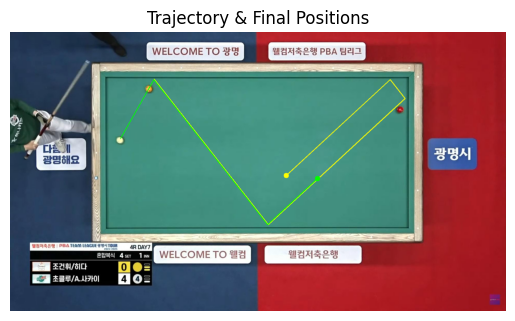

In [6]:
import pymunk
from pymunk import Vec2d
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt

##############################################################################
# 0) 헬퍼 함수: GPU 텐서 -> CPU float 변환
##############################################################################
def to_cpu_float(value):
    if isinstance(value, torch.Tensor):
        return float(value.detach().cpu().item())
    return float(value)

##############################################################################
# 1) 흰 공, 목표 공 좌표 추출 + 테이블 좌표
##############################################################################
white_ball = next(obj for obj in objects if obj["cls_name"] == "white ball")
target_ball = next(obj for obj in objects if obj["cls_name"] in ["red ball", "yellow ball"])

# x1, y1, x2, y2 좌표를 안전하게 변환
wx1, wy1 = to_cpu_float(white_ball["x1"]), to_cpu_float(white_ball["y1"])
wx2, wy2 = to_cpu_float(white_ball["x2"]), to_cpu_float(white_ball["y2"])
tx1, ty1 = to_cpu_float(target_ball["x1"]), to_cpu_float(target_ball["y1"])
tx2, ty2 = to_cpu_float(target_ball["x2"]), to_cpu_float(target_ball["y2"])

# 중심점 계산 (픽셀)
white_pos = np.array([(wx1 + wx2) / 2.0, (wy1 + wy2) / 2.0])
target_pos = np.array([(tx1 + tx2) / 2.0, (ty1 + ty2) / 2.0])

# 픽셀 → 월드 좌표 변환 스케일
PIXELS_TO_METERS = 100.0
white_pos_world = (white_pos / PIXELS_TO_METERS).tolist()
target_pos_world = (target_pos / PIXELS_TO_METERS).tolist()

##############################################################################
# 2) Pymunk 초기화 + 테이블 경계 생성
##############################################################################
space = pymunk.Space()
space.gravity = (0, 0)

table_world_min = (table["x1"] / PIXELS_TO_METERS, table["y1"] / PIXELS_TO_METERS)
table_world_max = (table["x2"] / PIXELS_TO_METERS, table["y2"] / PIXELS_TO_METERS)

cushion_thickness = 0.01
cushions = [
    pymunk.Segment(space.static_body, 
                   (table_world_min[0], table_world_min[1]), 
                   (table_world_max[0], table_world_min[1]), 
                   cushion_thickness),
    pymunk.Segment(space.static_body, 
                   (table_world_min[0], table_world_max[1]), 
                   (table_world_max[0], table_world_max[1]), 
                   cushion_thickness),
    pymunk.Segment(space.static_body, 
                   (table_world_min[0], table_world_min[1]), 
                   (table_world_min[0], table_world_max[1]), 
                   cushion_thickness),
    pymunk.Segment(space.static_body, 
                   (table_world_max[0], table_world_min[1]), 
                   (table_world_max[0], table_world_max[1]), 
                   cushion_thickness),
]
for c in cushions:
    c.elasticity = 0.85  # 반사력 조정
    c.friction = 0.01  # 쿠션 마찰 추가
    space.add(c)

##############################################################################
# 3) 공 생성 (동적)
##############################################################################
mass = 1.0
radius = 0.05  # 반지름: 5cm
moment = pymunk.moment_for_circle(mass, 0, radius)

# 흰 공
white_ball_body = pymunk.Body(mass, moment)
white_ball_body.position = white_pos_world
white_ball_shape = pymunk.Circle(white_ball_body, radius)
white_ball_shape.elasticity = 0.85
white_ball_shape.friction = 0.05  # 마찰 증가
white_ball_shape.collision_type = 0
space.add(white_ball_body, white_ball_shape)

# 목표 공
target_ball_body = pymunk.Body(mass, moment)
target_ball_body.position = target_pos_world
target_ball_shape = pymunk.Circle(target_ball_body, radius)
target_ball_shape.elasticity = 0.85
target_ball_shape.friction = 0.05
target_ball_shape.collision_type = 1
space.add(target_ball_body, target_ball_shape)

##############################################################################
# 4) 충돌 핸들러 등록
##############################################################################
def handle_collision(arbiter, space, data):
    """충돌 발생 시 속도를 조정"""
    shapes = arbiter.shapes
    white_body = shapes[0].body
    target_body = shapes[1].body

    # 충돌 후 속도 감소 (에너지 손실 반영)
    white_body.velocity *= 0.8  # 속도 감소
    target_body.velocity *= 0.8

    print(f"[충돌 발생] 흰 공 속도: {white_body.velocity}, 목표 공 속도: {target_body.velocity}")
    return True  # 충돌 유지

collision_handler = space.add_collision_handler(0, 1)
collision_handler.post_solve = handle_collision

##############################################################################
# 5) 흰 공 초기 속도 부여
##############################################################################
direction_vector = (target_ball_body.position - white_ball_body.position)
distance = direction_vector.length
direction_unit = direction_vector.normalized() if distance > 0 else pymunk.Vec2d(1, 0)

strength = min((distance / 15.0) * 10, 10)  # 최대 거리 15m 기준
white_ball_body.velocity = direction_unit * strength * 2.0

##############################################################################
# 6) 시뮬레이션 수행
##############################################################################
friction_coefficient = 0.02
dt = 1/60.0
max_steps = 3000
stop_threshold = 0.01

positions_w, positions_t = [], []

for step in range(max_steps):
    space.step(dt)

    # 속도가 매우 낮아지면 공 멈춤 처리
    if white_ball_body.velocity.length < stop_threshold:
        white_ball_body.velocity = Vec2d(0, 0)
    if target_ball_body.velocity.length < stop_threshold:
        target_ball_body.velocity = Vec2d(0, 0)

    # 각 공의 위치 저장
    positions_w.append((white_ball_body.position.x, white_ball_body.position.y))
    positions_t.append((target_ball_body.position.x, target_ball_body.position.y))

    # 두 공이 멈추면 종료
    if white_ball_body.velocity.length < stop_threshold and target_ball_body.velocity.length < stop_threshold:
        print(f"[시뮬레이션 종료] Step {step}")
        break

##############################################################################
# 7) 최종 결과 출력 및 궤적 시각화
##############################################################################
# 최종 위치 픽셀 변환
final_white_pos = white_ball_body.position * PIXELS_TO_METERS
final_target_pos = target_ball_body.position * PIXELS_TO_METERS

print(f"[최종 위치] 흰 공: ({final_white_pos.x:.2f}, {final_white_pos.y:.2f})")
print(f"[최종 위치] 목표 공: ({final_target_pos.x:.2f}, {final_target_pos.y:.2f})")

# 궤적 시각화
image = cv2.imread(image_path)
for i in range(len(positions_w) - 1):
    px_w1, py_w1 = int(positions_w[i][0] * PIXELS_TO_METERS), int(positions_w[i][1] * PIXELS_TO_METERS)
    px_w2, py_w2 = int(positions_w[i+1][0] * PIXELS_TO_METERS), int(positions_w[i+1][1] * PIXELS_TO_METERS)

    px_t1, py_t1 = int(positions_t[i][0] * PIXELS_TO_METERS), int(positions_t[i][1] * PIXELS_TO_METERS)
    px_t2, py_t2 = int(positions_t[i+1][0] * PIXELS_TO_METERS), int(positions_t[i+1][1] * PIXELS_TO_METERS)

    cv2.line(image, (px_w1, py_w1), (px_w2, py_w2), (0, 255, 0), 2)
    cv2.line(image, (px_t1, py_t1), (px_t2, py_t2), (0, 255, 255), 2)

cv2.circle(image, (int(final_white_pos.x), int(final_white_pos.y)), 10, (0, 255, 0), -1)
cv2.circle(image, (int(final_target_pos.x), int(final_target_pos.y)), 10, (0, 255, 255), -1)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis("off")
plt.title("Trajectory & Final Positions")
plt.show()


[초기 설정] 흰 공 초기 속도: Vec2d(1.974046639298664, -3.4789567208968917), 힘: 2
[Step 0] 흰 공 속도: 4.00, 목표 공 속도: 0.00
[충돌 발생] 법선 벡터: Vec2d(0.49351165982473194, -0.8697391802241854)
[충돌 발생] 충격량(impulse): Vec2d(-0.9672828532564745, 1.7046887932394033)
[충돌 발생] 흰 공 속도: Vec2d(1.2772081756261784, -2.250884998420321), 목표 공 속도: Vec2d(0.6968384636724854, -1.2280717224765705)
[충돌 발생] 법선 벡터: Vec2d(0.49351165982478024, -0.869739180224158)
[충돌 발생] 충격량(impulse): Vec2d(-0.2843811588574313, 0.5011785052123686)
[충돌 발생] 흰 공 속도: Vec2d(1.0723376673064502, -1.8898319120122196), 목표 공 속도: Vec2d(0.9017089719922138, -1.5891248088846721)
[충돌 발생] 법선 벡터: Vec2d(0.49351165982485673, -0.8697391802241147)
[충돌 발생] 충격량(impulse): Vec2d(-0.08360806070409786, 0.1473464805324292)
[충돌 발생] 흰 공 속도: Vec2d(1.0121057378604408, -1.783682304608243), 목표 공 속도: Vec2d(0.9619409014382232, -1.6952744162886486)
[충돌 발생] 법선 벡터: Vec2d(0.4935116598249288, -0.8697391802240736)
[충돌 발생] 충격량(impulse): Vec2d(-0.02458076984700838, 0.04331986527653218)
[충돌 발

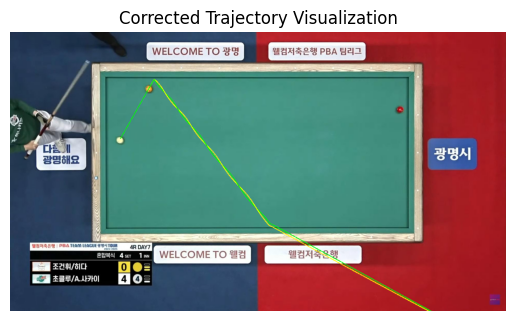

In [14]:
import pymunk
from pymunk import Vec2d
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt

##############################################################################
# 0) 헬퍼 함수: GPU 텐서 -> CPU float 변환
##############################################################################
def to_cpu_float(value):
    if isinstance(value, torch.Tensor):
        return float(value.detach().cpu().item())
    return float(value)

##############################################################################
# 1) 흰 공, 목표 공 좌표 추출 + 테이블 좌표
##############################################################################
white_ball = next(obj for obj in objects if obj["cls_name"] == "white ball")
target_ball = next(obj for obj in objects if obj["cls_name"] in ["red ball", "yellow ball"])

# x1, y1, x2, y2 좌표를 안전하게 변환
wx1, wy1 = to_cpu_float(white_ball["x1"]), to_cpu_float(white_ball["y1"])
wx2, wy2 = to_cpu_float(white_ball["x2"]), to_cpu_float(white_ball["y2"])
tx1, ty1 = to_cpu_float(target_ball["x1"]), to_cpu_float(target_ball["y1"])
tx2, ty2 = to_cpu_float(target_ball["x2"]), to_cpu_float(target_ball["y2"])

# 중심점 계산 (픽셀)
white_pos = np.array([(wx1 + wx2) / 2.0, (wy1 + wy2) / 2.0])
target_pos = np.array([(tx1 + tx2) / 2.0, (ty1 + ty2) / 2.0])

# 픽셀 → 월드 좌표 변환 스케일
PIXELS_TO_METERS = 100.0
white_pos_world = (white_pos / PIXELS_TO_METERS).tolist()
target_pos_world = (target_pos / PIXELS_TO_METERS).tolist()

##############################################################################
# 2) Pymunk 초기화 + 테이블 경계 생성
##############################################################################
space = pymunk.Space()
space.gravity = (0, 0)

table_world_min = (table["x1"] / PIXELS_TO_METERS, table["y1"] / PIXELS_TO_METERS)
table_world_max = (table["x2"] / PIXELS_TO_METERS, table["y2"] / PIXELS_TO_METERS)

cushion_thickness = 0.01
cushions = [
    pymunk.Segment(space.static_body, 
                   (table_world_min[0], table_world_min[1]), 
                   (table_world_max[0], table_world_min[1]), 
                   cushion_thickness),
    pymunk.Segment(space.static_body, 
                   (table_world_min[0], table_world_max[1]), 
                   (table_world_max[0], table_world_max[1]), 
                   cushion_thickness),
    pymunk.Segment(space.static_body, 
                   (table_world_min[0], table_world_min[1]), 
                   (table_world_min[0], table_world_max[1]), 
                   cushion_thickness),
    pymunk.Segment(space.static_body, 
                   (table_world_max[0], table_world_min[1]), 
                   (table_world_max[0], table_world_max[1]), 
                   cushion_thickness),
]
for c in cushions:
    c.elasticity = 0.7  # 현실적인 반사 각도
    c.friction = 0.1  # 쿠션 마찰 추가
    space.add(c)

##############################################################################
# 3) 공 생성 (동적)
##############################################################################
mass = 1.0
radius = 0.05  # 반지름: 5cm
moment = pymunk.moment_for_circle(mass, 0, radius)

# 흰 공
white_ball_body = pymunk.Body(mass, moment)
white_ball_body.position = white_pos_world
white_ball_shape = pymunk.Circle(white_ball_body, radius)
white_ball_shape.elasticity = 0.7
white_ball_shape.friction = 0.1  # 마찰 증가
white_ball_shape.collision_type = 0
space.add(white_ball_body, white_ball_shape)

# 목표 공
target_ball_body = pymunk.Body(mass, moment)
target_ball_body.position = target_pos_world
target_ball_shape = pymunk.Circle(target_ball_body, radius)
target_ball_shape.elasticity = 0.7
target_ball_shape.friction = 0.1  # 마찰 증가
target_ball_shape.collision_type = 1
space.add(target_ball_body, target_ball_shape)

# 방향 벡터 및 초기 속도 계산 강화
direction_vector = (target_ball_body.position - white_ball_body.position)
distance = direction_vector.length
direction_unit = direction_vector.normalized() if distance > 0 else pymunk.Vec2d(1, 0)

# 초기 속도 설정 (속도가 너무 작지 않도록 조정)
strength = max(min((distance / 15.0) * 10, 10), 2)  # 최소 속도 2 설정
white_ball_body.velocity = direction_unit * strength * 2.0

print(f"[초기 설정] 흰 공 초기 속도: {white_ball_body.velocity}, 힘: {strength}")


##############################################################################
# 충돌 핸들러: 충돌 후 각 공의 속도와 방향 계산
##############################################################################
def handle_collision(arbiter, space, data):
    """충돌 발생 시 속도를 조정"""
    shapes = arbiter.shapes
    white_body = shapes[0].body
    target_body = shapes[1].body

    # 충돌 법선 벡터
    collision_normal = arbiter.contact_point_set.normal

    # 상대 속도 계산
    relative_velocity = white_body.velocity - target_body.velocity
    impulse = relative_velocity.dot(collision_normal) * collision_normal

    # 충돌 후 속도 계산
    white_body.velocity -= impulse * 0.8  # 흰 공 속도 감소
    target_body.velocity += impulse * 0.8  # 목표 공 속도 증가

    # 디버깅 로그 출력
    print(f"[충돌 발생] 법선 벡터: {collision_normal}")
    print(f"[충돌 발생] 충격량(impulse): {impulse}")
    print(f"[충돌 발생] 흰 공 속도: {white_body.velocity}, 목표 공 속도: {target_body.velocity}")
    return True

# 충돌 핸들러 등록
collision_handler = space.add_collision_handler(0, 1)
collision_handler.post_solve = handle_collision

##############################################################################
# 시뮬레이션 수행 (충돌 후 각 공의 궤적 분리)
##############################################################################
friction_coefficient = 0.01  # 마찰 계수 낮춤
dt = 1 / 60.0
max_steps = 3000
stop_threshold = 0.02  # 멈춤 기준 낮춤

positions_w, positions_t = [], []  # 흰 공과 목표 공의 궤적 저장

for step in range(max_steps):
    space.step(dt)

    # 속도가 매우 낮아지면 공 멈춤 처리
    if white_ball_body.velocity.length < stop_threshold:
        white_ball_body.velocity = Vec2d(0, 0)
    if target_ball_body.velocity.length < stop_threshold:
        target_ball_body.velocity = Vec2d(0, 0)

    # 각 공의 위치 저장
    positions_w.append((white_ball_body.position.x, white_ball_body.position.y))
    positions_t.append((target_ball_body.position.x, target_ball_body.position.y))

    # 디버깅 로그
    if step % 100 == 0:
        print(f"[Step {step}] 흰 공 속도: {white_ball_body.velocity.length:.2f}, 목표 공 속도: {target_ball_body.velocity.length:.2f}")

    # 두 공이 모두 멈추면 종료
    if white_ball_body.velocity.length < stop_threshold and target_ball_body.velocity.length < stop_threshold:
        print(f"[시뮬레이션 종료] Step {step}")
        break

##############################################################################
# 최종 궤적 시각화
##############################################################################
# 최종 위치 변환 (픽셀)
final_white_pos = white_ball_body.position * PIXELS_TO_METERS
final_target_pos = target_ball_body.position * PIXELS_TO_METERS

print(f"[최종 위치] 흰 공: ({final_white_pos.x:.2f}, {final_white_pos.y:.2f})")
print(f"[최종 위치] 목표 공: ({final_target_pos.x:.2f}, {final_target_pos.y:.2f})")

# OpenCV로 궤적 시각화
image = cv2.imread(image_path)
for i in range(len(positions_w) - 1):
    # 흰 공 궤적
    px_w1, py_w1 = int(positions_w[i][0] * PIXELS_TO_METERS), int(positions_w[i][1] * PIXELS_TO_METERS)
    px_w2, py_w2 = int(positions_w[i + 1][0] * PIXELS_TO_METERS), int(positions_w[i + 1][1] * PIXELS_TO_METERS)
    cv2.line(image, (px_w1, py_w1), (px_w2, py_w2), (0, 255, 0), 2)  # 초록색 선

    # 목표 공 궤적
    px_t1, py_t1 = int(positions_t[i][0] * PIXELS_TO_METERS), int(positions_t[i][1] * PIXELS_TO_METERS)
    px_t2, py_t2 = int(positions_t[i + 1][0] * PIXELS_TO_METERS), int(positions_t[i + 1][1] * PIXELS_TO_METERS)
    cv2.line(image, (px_t1, py_t1), (px_t2, py_t2), (0, 255, 255), 2)  # 노란색 선

# 최종 위치 표시
cv2.circle(image, (int(final_white_pos.x), int(final_white_pos.y)), 10, (0, 255, 0), -1)  # 흰 공
cv2.circle(image, (int(final_target_pos.x), int(final_target_pos.y)), 10, (0, 255, 255), -1)  # 목표 공

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis("off")
plt.title("Corrected Trajectory Visualization")
plt.show()



Exception ignored from cffi callback <function ext_cpCollisionPostSolveFunc at 0x7a791e13c040>:
Traceback (most recent call last):
  File "/aiffel/myenv/lib/python3.9/site-packages/pymunk/_callbacks.py", line 253, in ext_cpCollisionPostSolveFunc
    handler._post_solve(Arbiter(_arb, handler._space), handler._space, handler.data)
  File "/tmp/ipykernel_80/4043997022.py", line 11, in handle_collision
AttributeError: 'ContactPoint' object has no attribute 'normal'
Exception ignored from cffi callback <function ext_cpCollisionPostSolveFunc at 0x7a791e13c040>:
Traceback (most recent call last):
  File "/aiffel/myenv/lib/python3.9/site-packages/pymunk/_callbacks.py", line 253, in ext_cpCollisionPostSolveFunc
    handler._post_solve(Arbiter(_arb, handler._space), handler._space, handler.data)
  File "/tmp/ipykernel_80/4043997022.py", line 11, in handle_collision
AttributeError: 'ContactPoint' object has no attribute 'normal'
Exception ignored from cffi callback <function ext_cpCollisionPostSo

[Step 0] 흰 공 속도: 0.25, 목표 공 속도: 0.36
[Step 100] 흰 공 속도: 0.25, 목표 공 속도: 0.36
[Step 200] 흰 공 속도: 0.25, 목표 공 속도: 0.36
[Step 300] 흰 공 속도: 0.25, 목표 공 속도: 0.36
[Step 400] 흰 공 속도: 0.25, 목표 공 속도: 0.36
[Step 500] 흰 공 속도: 0.25, 목표 공 속도: 0.36
[Step 600] 흰 공 속도: 0.25, 목표 공 속도: 0.21
[Step 700] 흰 공 속도: 0.25, 목표 공 속도: 0.21
[Step 800] 흰 공 속도: 0.25, 목표 공 속도: 0.21
[Step 900] 흰 공 속도: 0.25, 목표 공 속도: 0.21
[Step 1000] 흰 공 속도: 0.25, 목표 공 속도: 0.21
[Step 1100] 흰 공 속도: 0.25, 목표 공 속도: 0.21
[Step 1200] 흰 공 속도: 0.15, 목표 공 속도: 0.21
[Step 1300] 흰 공 속도: 0.15, 목표 공 속도: 0.21
[Step 1400] 흰 공 속도: 0.15, 목표 공 속도: 0.21
[Step 1500] 흰 공 속도: 0.15, 목표 공 속도: 0.17
[Step 1600] 흰 공 속도: 0.15, 목표 공 속도: 0.17
[Step 1700] 흰 공 속도: 0.15, 목표 공 속도: 0.17
[Step 1800] 흰 공 속도: 0.15, 목표 공 속도: 0.17
[Step 1900] 흰 공 속도: 0.15, 목표 공 속도: 0.17
[Step 2000] 흰 공 속도: 0.15, 목표 공 속도: 0.17
[Step 2100] 흰 공 속도: 0.15, 목표 공 속도: 0.17
[Step 2200] 흰 공 속도: 0.15, 목표 공 속도: 0.17
[Step 2300] 흰 공 속도: 0.15, 목표 공 속도: 0.17
[Step 2400] 흰 공 속도: 0.15, 목표 공 속도: 0.17
[Step 2500] 

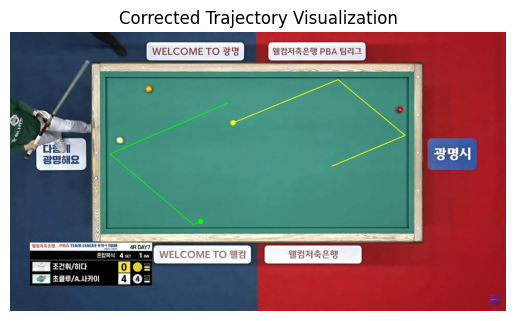


0: 960x1280 1 frame, 1 red ball, 1 table, 1 white ball, 1 yellow ball, 47.1ms
Speed: 7.3ms preprocess, 47.1ms inference, 1.4ms postprocess per image at shape (1, 3, 960, 1280)
Table: {'cls_name': 'table', 'x1': tensor(162.2174, device='cuda:0'), 'y1': tensor(139.9791, device='cuda:0'), 'x2': tensor(640.4391, device='cuda:0'), 'y2': tensor(458.9340, device='cuda:0'), 'confidence': tensor(0.9353, device='cuda:0')}
Objects: [{'cls_name': 'red ball', 'x1': tensor(320.3600, device='cuda:0'), 'y1': tensor(352.4736, device='cuda:0'), 'x2': tensor(332.1679, device='cuda:0'), 'y2': tensor(368.5248, device='cuda:0'), 'confidence': tensor(0.9076, device='cuda:0')}, {'cls_name': 'white ball', 'x1': tensor(485.0409, device='cuda:0'), 'y1': tensor(201.7920, device='cuda:0'), 'x2': tensor(498.0943, device='cuda:0'), 'y2': tensor(218.3446, device='cuda:0'), 'confidence': tensor(0.8909, device='cuda:0')}, {'cls_name': 'yellow ball', 'x1': tensor(451.0173, device='cuda:0'), 'y1': tensor(346.7769, devic

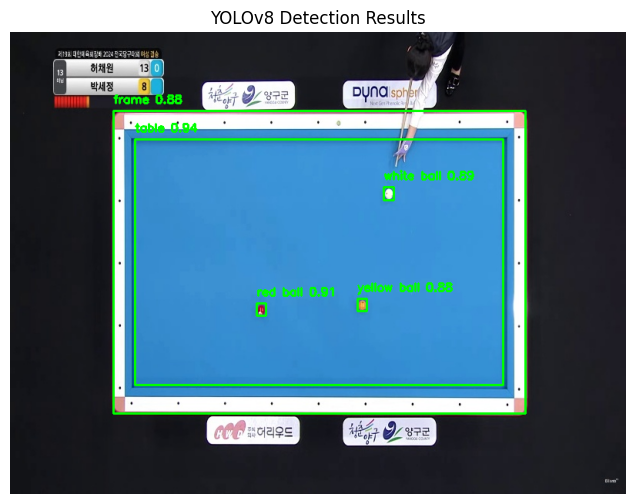

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline  

from ultralytics import YOLO
import cv2
import torch

# 1) YOLO 모델 로드
model_path = "best_jihye.pt"
model = YOLO(model_path)

# 2) 이미지 로드
image_path = "test_img_2nd.jpg"
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Could not load image: {image_path}")

# 3) 모델 추론
results = model.predict(source=image, conf=0.5)

# 4) 당구대, 공, 프레임 등 저장할 구조
table = None
objects = []

# 5) 바운딩 박스 표시
for result in results:
    for box in result.boxes:
        # 바운딩 박스 정보
        x1, y1, x2, y2 = box.xyxy[0]
        conf = box.conf[0]
        cls_id = int(box.cls[0])

        # 사각형 그리기 위한 int 변환
        ix1, iy1, ix2, iy2 = map(int, [x1, y1, x2, y2])

        # 클래스 ID → 이름 매핑
        class_map = {
            0: "blue ball", 
            1: "frame", 
            2: "red ball", 
            3: "table",
            4: "white ball", 
            5: "yellow ball"
        }
        cls_name = class_map.get(cls_id, f"Unknown({cls_id})")

        # OpenCV로 바운딩 박스 그리기
        cv2.rectangle(image, (ix1, iy1), (ix2, iy2), (0, 255, 0), 2)

        # 라벨(클래스명 + 신뢰도) 표시
        label = f"{cls_name} {conf:.2f}"
        cv2.putText(
            image, label, (ix1, max(iy1 - 10, 0)),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2
        )

        # 아래는 원하는 로직에 따라 table/objects 분류
        if cls_id == 3:  # table
            table = {
                "cls_name": "table",
                "x1": x1, "y1": y1, "x2": x2, "y2": y2,
                "confidence": conf
            }
        else:
            objects.append({
                "cls_name": cls_name,
                "x1": x1, "y1": y1, "x2": x2, "y2": y2,
                "confidence": conf
            })

# 테이블 없으면 기본값
if table is None:
    table = {
        "cls_name": "table(default)",
        "x1": 0, "y1": 0, "x2": 1280, "y2": 720,
        "confidence": 1.0
    }

print("Table:", table)
print("Objects:", objects)

# 시각화(디버깅용)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("YOLOv8 Detection Results")
plt.show()


[충돌] bodyA vel=Vec2d(-0.026278145287823303, 0.02391384842814412), bodyB vel=Vec2d(-0.25033391037350616, 0.22781087186807494)
[최종 위치] 흰 공: (275.95, 406.29)
[최종 위치] 목표 공: (615.73, 293.26)


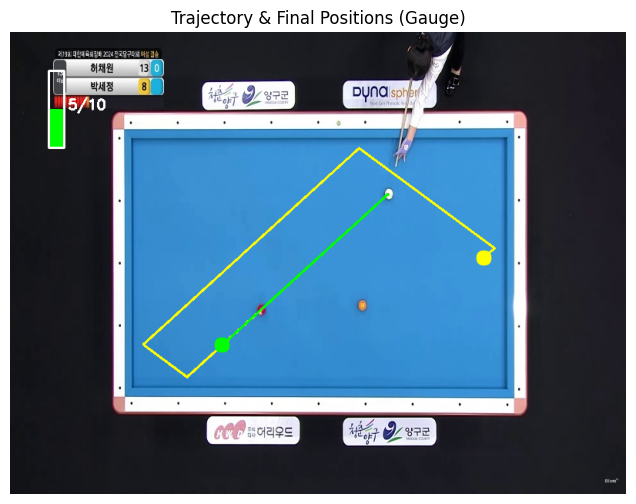

In [32]:
import pymunk
from pymunk import Vec2d
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt

##############################################################################
# 0) 헬퍼 함수: GPU 텐서 -> CPU float 변환
##############################################################################
def to_cpu_float(value):
    if isinstance(value, torch.Tensor):
        return float(value.detach().cpu().item())
    return float(value)

##############################################################################
# 1) 흰 공, 목표 공 좌표 추출 + 테이블 좌표
##############################################################################
white_ball = next(obj for obj in objects if obj["cls_name"] == "white ball")
target_ball = next(obj for obj in objects if obj["cls_name"] in ["red ball", "yellow ball"])

# x1, y1, x2, y2 좌표를 안전하게 변환
wx1, wy1 = to_cpu_float(white_ball["x1"]), to_cpu_float(white_ball["y1"])
wx2, wy2 = to_cpu_float(white_ball["x2"]), to_cpu_float(white_ball["y2"])
tx1, ty1 = to_cpu_float(target_ball["x1"]), to_cpu_float(target_ball["y1"])
tx2, ty2 = to_cpu_float(target_ball["x2"]), to_cpu_float(target_ball["y2"])

# 중심점 계산 (픽셀)
white_pos = np.array([(wx1 + wx2) / 2.0, (wy1 + wy2) / 2.0])
target_pos = np.array([(tx1 + tx2) / 2.0, (ty1 + ty2) / 2.0])

# 픽셀 → 월드 좌표 변환 스케일
PIXELS_TO_METERS = 100.0
white_pos_world = (white_pos / PIXELS_TO_METERS).tolist()
target_pos_world = (target_pos / PIXELS_TO_METERS).tolist()

##############################################################################
# 2) Pymunk 초기화
##############################################################################
space = pymunk.Space()
space.gravity = (0, 0)

# 테이블 좌하단, 우상단 (월드 좌표)
table_min_x = table["x1"] / PIXELS_TO_METERS
table_min_y = table["y1"] / PIXELS_TO_METERS
table_max_x = table["x2"] / PIXELS_TO_METERS
table_max_y = table["y2"] / PIXELS_TO_METERS

##############################################################################
# 3) 공 생성에 필요한 파라미터
##############################################################################
mass = 1.0
radius = 0.05  # 5cm
moment = pymunk.moment_for_circle(mass, 0, radius)

##############################################################################
# 4) 테이블 경계 생성 - 쿠션(4개 세그먼트)
##############################################################################
# 공이 테이블 밖으로 안 나가도록, '공의 반지름'만큼 테이블 안쪽에 쿠션을 배치.
# 즉 쿠션 라인을 (테이블 꼭짓점 ± radius)만큼 안쪽으로 잡는다.
left   = table_min_x + radius
right  = table_max_x - radius
bottom = table_min_y + radius
top    = table_max_y - radius

cushion_thickness = 0.01
cushions = [
    pymunk.Segment(space.static_body, (left, bottom), (right, bottom), cushion_thickness),
    pymunk.Segment(space.static_body, (left, top),    (right, top),    cushion_thickness),
    pymunk.Segment(space.static_body, (left, bottom), (left, top),     cushion_thickness),
    pymunk.Segment(space.static_body, (right, bottom),(right, top),    cushion_thickness),
]
for c in cushions:
    c.elasticity = 0.9   # 반사력
    c.friction = 0.01    # 쿠션과의 마찰
    space.add(c)

##############################################################################
# 5) 흰 공과 노란 공(또는 빨간 공) 생성
##############################################################################
# 흰 공
white_ball_body = pymunk.Body(mass, moment)
white_ball_body.position = white_pos_world
white_ball_shape = pymunk.Circle(white_ball_body, radius)
white_ball_shape.elasticity = 0.9
white_ball_shape.friction = 0.05
white_ball_shape.collision_type = 1
space.add(white_ball_body, white_ball_shape)

# 목표 공
target_ball_body = pymunk.Body(mass, moment)
target_ball_body.position = target_pos_world
target_ball_shape = pymunk.Circle(target_ball_body, radius)
target_ball_shape.elasticity = 0.9
target_ball_shape.friction = 0.05
target_ball_shape.collision_type = 2
space.add(target_ball_body, target_ball_shape)

##############################################################################
# 6) 충돌 핸들러 등록
##############################################################################
def on_collision(arbiter, space, data):
    """
    Pymunk 기본 탄성 처리에 맡기되, 로그만 출력(필요하다면).
    충돌 시 속도를 억지로 같게 만들거나 조정하지 않음.
    """
    shapes = arbiter.shapes
    bodyA = shapes[0].body
    bodyB = shapes[1].body
    print(f"[충돌] bodyA vel={bodyA.velocity}, bodyB vel={bodyB.velocity}")
    return True

collision_handler = space.add_collision_handler(1, 2)
# 굳이 post_solve 등에서 속도를 수정하지 않고, Pymunk의 탄성 충돌 처리에 맡긴다.
collision_handler.post_solve = on_collision

##############################################################################
# 7) 흰 공 초기 속도(게이지) 부여
##############################################################################
# 게이지 1~10 → 최대가 5 m/s (기존대비 절반 수준)
strength_gauge = 5  # 예시
max_speed = 5.0
initial_speed = (strength_gauge / 60.0) * max_speed  # 게이지 10이면 5 m/s

# 흰 공에서 목표 공까지 방향
direction_vec = (target_ball_body.position - white_ball_body.position)
distance = direction_vec.length
direction_unit = direction_vec.normalized() if distance > 0 else Vec2d(1, 0)

# 초기 속도 설정
white_ball_body.velocity = direction_unit * initial_speed

##############################################################################
# 8) 시뮬레이션 실행
##############################################################################
dt = 1/60.0
max_steps = 3000
stop_threshold = 0.02

positions_w, positions_t = [], []

# 마찰(테이블 전체) 고려를 위해, 매 스텝마다 velocity를 약간씩 감소시키는 방법
# (Pymunk의 friction도 있지만, 효과를 좀 더 명확히 하고 싶으면 추가로 사용)
global_friction_coef = 0.02

for step in range(max_steps):
    space.step(dt)

    # 추가적인 마찰 감소(테이블에서 구르는 효과)
    white_ball_body.velocity *= (1 - global_friction_coef * dt)
    target_ball_body.velocity *= (1 - global_friction_coef * dt)

    # 속도가 매우 낮으면 멈춤 처리
    if white_ball_body.velocity.length < stop_threshold:
        white_ball_body.velocity = Vec2d(0, 0)
    if target_ball_body.velocity.length < stop_threshold:
        target_ball_body.velocity = Vec2d(0, 0)

    positions_w.append((white_ball_body.position.x, white_ball_body.position.y))
    positions_t.append((target_ball_body.position.x, target_ball_body.position.y))

    # 둘 다 멈추면 종료
    if (white_ball_body.velocity.length == 0 and
        target_ball_body.velocity.length == 0):
        print(f"[시뮬레이션 종료] Step {step}")
        break

##############################################################################
# 9) 결과 출력
##############################################################################
final_white_pos = white_ball_body.position * PIXELS_TO_METERS
final_target_pos = target_ball_body.position * PIXELS_TO_METERS

print(f"[최종 위치] 흰 공: ({final_white_pos.x:.2f}, {final_white_pos.y:.2f})")
print(f"[최종 위치] 목표 공: ({final_target_pos.x:.2f}, {final_target_pos.y:.2f})")

##############################################################################
# 10) 궤적 시각화
##############################################################################
image = cv2.imread(image_path)

# 궤적
for i in range(len(positions_w) - 1):
    px_w1, py_w1 = int(positions_w[i][0] * PIXELS_TO_METERS), int(positions_w[i][1] * PIXELS_TO_METERS)
    px_w2, py_w2 = int(positions_w[i+1][0] * PIXELS_TO_METERS), int(positions_w[i+1][1] * PIXELS_TO_METERS)
    cv2.line(image, (px_w1, py_w1), (px_w2, py_w2), (0, 255, 0), 2)

    px_t1, py_t1 = int(positions_t[i][0] * PIXELS_TO_METERS), int(positions_t[i][1] * PIXELS_TO_METERS)
    px_t2, py_t2 = int(positions_t[i+1][0] * PIXELS_TO_METERS), int(positions_t[i+1][1] * PIXELS_TO_METERS)
    cv2.line(image, (px_t1, py_t1), (px_t2, py_t2), (0, 255, 255), 2)

# 최종 위치
cv2.circle(image, (int(final_white_pos.x), int(final_white_pos.y)), 10, (0, 255, 0), -1)
cv2.circle(image, (int(final_target_pos.x), int(final_target_pos.y)), 10, (0, 255, 255), -1)

##############################################################################
# 11) 강도 게이지 표시 (좌측 상단)
##############################################################################
gauge_max_height = 100
gauge_height = int((strength_gauge / 10) * gauge_max_height)
gauge_x, gauge_y = 50, 50
gauge_width = 20

cv2.rectangle(
    image,
    (gauge_x, gauge_y + gauge_max_height - gauge_height),
    (gauge_x + gauge_width, gauge_y + gauge_max_height),
    (0, 255, 0),
    -1
)
cv2.rectangle(
    image,
    (gauge_x, gauge_y),
    (gauge_x + gauge_width, gauge_y + gauge_max_height),
    (255, 255, 255),
    2
)
cv2.putText(
    image,
    f"{strength_gauge}/10",
    (gauge_x + gauge_width + 5, gauge_y + gauge_max_height // 2),
    cv2.FONT_HERSHEY_SIMPLEX,
    0.6,
    (255, 255, 255),
    2
)

# 결과 시각화
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 6))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("Trajectory & Final Positions (Gauge)")
plt.show()
